In [1]:
import numpy as np
from tqdm import tqdm
import math
import random
import matplotlib.pyplot as plt
import statistics
from sklearn.preprocessing import normalize

In [2]:
#parameters

from scipy.io import loadmat
stocks = loadmat('data/data_490_1000.mat')

stocks_shape = stocks['A'].shape
number_of_stocks = stocks_shape[0]
number_of_trades = stocks_shape[1]
T = number_of_trades
D = math.sqrt(2)
G = 1
step = D / (G * math.sqrt(T))
num_of_simulations = 5

In [3]:
#calculating the loss

def loss(x, r_t):
    return -log(np.transpose(x)*r_t)

# revanue in time t
def revanue(x, r_t, wealth):
    return np.dot(np.transpose(x), r_t) * wealth

# normalize vector

def normalize_func(x):
    sum_x = np.sum(x)
    x = x/sum_x
    return x

# gradient vector
def gradient(x, r_t):
    #xTrt
    xTrt = np.dot(np.transpose(x), r_t)
    #scalar
    scalar = -1 / xTrt
    grad = scalar * r_t
    return grad

In [8]:
#get r materix
def get_r_matrix(number_of_stocks, number_of_trades, stocks):
    r_matrix = np.zeros([number_of_stocks, number_of_trades-1])
    for stock in range(number_of_stocks):
        for trade in range(number_of_trades-1):
            r_matrix[stock][trade] = (stocks['A'][stock][trade + 1])/(stocks['A'][stock][trade])
    return r_matrix

#fixed_stock_solution
def best_fixed_stock_solution_func(number_of_trades, number_of_stocks, r_matrix):
    best_fixed_stock_solution = np.zeros(number_of_trades)
    for trade in range(number_of_trades-1):
        max = None
        for stock in range(number_of_stocks):
            if max == None or r_matrix[stock][trade] > max:
                best_fixed_stock_solution[trade] = stock
                max = r_matrix[stock][trade]
    return best_fixed_stock_solution

# best_rebalnce_solution
def best_rebalnce_solution(number_of_trades, r_matrix, number_of_stocks):
    best_fixed_stock_solution = best_fixed_stock_solution_func(number_of_trades, number_of_stocks, r_matrix)
    best_rebalnce_solution_wealth = np.zeros(number_of_trades)
    best_rebalnce_solution_wealth [0] = 1
    for trade in range(1,number_of_trades):
        best_rebalnce_solution_wealth[trade] = best_rebalnce_solution_wealth[trade-1] * r_matrix[int(best_fixed_stock_solution[trade-1])][trade-1]
    return best_rebalnce_solution_wealth

# best fixed stock
def fixed_stock_func(number_of_stocks, number_of_trades, r_matrix):
    all_stocks_wealth = np.zeros([number_of_stocks, number_of_trades])
    for stock in range(number_of_stocks):
        for trade in range(number_of_trades):
            if (trade == 0):
                all_stocks_wealth[stock][trade] = 1
                continue
            all_stocks_wealth[stock][trade] = all_stocks_wealth[stock][trade-1] * r_matrix[stock][trade-1]
    max = None
    index = None
    for stock in range(number_of_stocks):
        if ((max == None) or (all_stocks_wealth[stock][number_of_trades-1]>max)):
            max = all_stocks_wealth[stock][number_of_trades-1]
            index = stock
    return all_stocks_wealth[index, :]

In [17]:
#Online_gradient_descent
def Online_gradient_descent(x, r_matrix, number_of_trades, step):
    scores_OGD = np.zeros(number_of_trades)
#     x = np.zeros(rows)
    scores_OGD[0] += revanue(x, r_matrix[:,0], 1)
#     x_sum = [x]
    for i in range(1, number_of_trades):
#         for j in range(int(rows/batch_size)):
#             rand_indexes = np.random.randint(0, rows - 1, batch_size)
#             matrix_til = matrix[rand_indexes, :]
#             matrix_with_noise_til = matrix_with_noise[rand_indexes]
#             step = 2/(alpha*(j+1))
#             x = x - step * gradient(matrix_til,x,matrix_with_noise_til)/batch_size
        x = x - step * gradient(x,r_matrix[:,i-1])
        x = normalize_func(x)
        scores_OGD[i] += revanue(x, r_matrix[:,i-1], scores_OGD[i-1])
#         x_sum.append(x)
#         x_avg = sum(x_sum)/len(x_sum)
#         scores_SGD[i] += loss(matrix, x_avg, matrix_with_noise)
    return scores_OGD

In [18]:
def plot(final_OGD, final_EGD, final_ONS, final_rebalnce, final_fixed_stock, number_of_trades, num_of_simulations):
    if final_OGD is not 0:
        plt.plot(range(1, number_of_trades+1), final_OGD /  num_of_simulations, 'green')
    if final_EGD is not 0:
        plt.plot(range(1, number_of_trades+1), final_EGD /  num_of_simulations, 'red')
    if final_ONS is not 0:
        plt.plot(range(1, number_of_trades+1), final_ONS /  num_of_simulations, 'blue')
    if final_rebalnce is not 0:
        plt.plot(range(1, number_of_trades+1), final_rebalnce /  num_of_simulations, 'grey')
    if final_fixed_stock is not 0:
        plt.plot(range(1, number_of_trades+1), final_fixed_stock /  num_of_simulations, 'black')

    plt.legend(['OGD', 'EGD', 'ONS'
                , 'final_rebalnce', 'final_fixed_stock'], loc='best')
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    plt.ylabel('Wealth')
    plt.xlabel('number_of_trades')
    plt.title('ORPS methods comparison')
    plt.savefig('ORPS methods comparison.png')
    plt.show()

100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


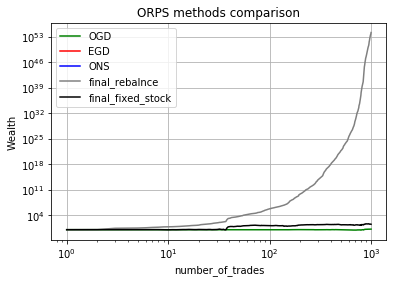

In [22]:
final_OGD = np.zeros(number_of_trades)
final_EGD = np.zeros(number_of_trades)
final_ONS = np.zeros(number_of_trades)
final_rebalnce = np.zeros(number_of_trades)
final_fixed_stock = np.zeros(number_of_trades)
for i in tqdm(range(num_of_simulations),total=num_of_simulations):
    x = np.zeros(number_of_stocks) + 1 
#     x += 1
    x = normalize_func(x)
    r_matrix = get_r_matrix(number_of_stocks, number_of_trades, stocks)

    OGD = Online_gradient_descent(x, r_matrix, number_of_trades, step)
#     EGD
#     ONS
    rebalnce = best_rebalnce_solution(number_of_trades, r_matrix, number_of_stocks)
    fixed_stock = fixed_stock_func(number_of_stocks, number_of_trades, r_matrix)
    final_OGD += OGD
#     final_EGD += EGD
#     final_ONS += ONS
    final_rebalnce += rebalnce
    final_fixed_stock += fixed_stock
    
# raise
plot(final_OGD, final_EGD, final_ONS, final_rebalnce, final_fixed_stock, number_of_trades, num_of_simulations)

In [3]:
# #creating the matrix based on the parameters we get
# def creating_matrix(max_range, min_range, rows, columns, x_noise_mean, x_noise_sd, b_noise_mean, b_noise_sd):
#     B = np.random.rand(rows, columns)
#     u, s, vh = np.linalg.svd(B, full_matrices=True)
#     s_new = np.zeros(s.shape)
#     s_new[0] = max_range
#     rank = min(rows, columns)
#     s_new[rank-1] = min_range
    
#     for i in range(min(rows, columns)):
#         if i == 0 or i == rank-1:
#             continue
#         s_new[i] = (random.uniform(0, 1)) * (max_range-min_range) + min_range

#     s_new.sort()
#     s_temp = np.copy(s_new)
#     for i in range(min(rows, columns)):
#         s_new[i] = s_temp[rank - 1 - i]

#     A = np.dot(u[:, :rank] * s_new, vh)
#     x = np.zeros(columns)
#     for i in range(columns):
#         x[i] = np.random.normal(x_noise_mean, x_noise_sd)
#     M = np.dot(A, x)
#     b = M + np.random.normal(b_noise_mean, b_noise_sd)
#     alpha = s_new[rank-1] * s_new[rank-1]
#     beta = s_new[0] * s_new[0]
#     b_norm = np.linalg.norm(b)
#     penrose_inverse = np.linalg.pinv(A)
#     R = np.linalg.norm(penrose_inverse) * np.linalg.norm(b)
#     L = beta * R + s_new[0] * b_norm
#     return b, A, alpha, beta, R, L


# #calculating the function value
# def loss(A, x, b):
#     return 0.5*np.linalg.norm(np.dot(A, x)-b)**2


# #calculating the gradient value
# def gradient(A, x, b):
#     return np.dot(np.transpose(A), (np.dot(A, x)-b))


# #ploting the results

    
# #batch Stochastic_gradient_descent
# def Stochastic_gradient_descent(iterations, rows, columns, matrix, matrix_with_noise, alpha, dim, beta, batch_size):
#     scores_SGD = np.zeros(iterations)
#     x = np.zeros(rows)
#     scores_SGD[0] += loss(matrix, x, matrix_with_noise)
#     x_sum = [x]
#     for i in range(1, iterations):
#         for j in range(int(rows/batch_size)):
#             rand_indexes = np.random.randint(0, rows - 1, batch_size)
#             matrix_til = matrix[rand_indexes, :]
#             matrix_with_noise_til = matrix_with_noise[rand_indexes]
#             step = 2/(alpha*(j+1))
#             x = x - step * gradient(matrix_til,x,matrix_with_noise_til)/batch_size
#         x_sum.append(x)
#         x_avg = sum(x_sum)/len(x_sum)
#         scores_SGD[i] += loss(matrix, x_avg, matrix_with_noise)
#     return scores_SGD

# #SVRG
# def SVRG_function(iterations, rows, columns, matrix, matrix_with_noise, alpha, dim, beta):
#     data_repeat = int(200 * beta / alpha)
#     number_of_iterations = iterations - int(2 * data_repeat/rows)
#     scores_SVRG = np.zeros(number_of_iterations)
#     SVRG_pass = []
#     x_prev = np.zeros(rows)
#     x_i = [x_prev]
#     scores_SVRG[0] = loss(matrix, x_prev, matrix_with_noise)
#     SVRG_pass.append(1)
#     for i in range(1,number_of_iterations):
#         if (i > 1):
#             x_prev = sum(list_x)/len(list_x)
#         x_j = x_prev
#         step = 1 / (10*beta)
#         list_x = [x_j]
#         gradient_score = gradient(matrix, x_prev, matrix_with_noise) / rows
#         for j in range(data_repeat):            
#             #get random i's
#             rand_indexes = np.random.randint(0, rows - 1, 1)
#             matrix_til = matrix[rand_indexes, :]
#             matrix_with_noise_til = matrix_with_noise[rand_indexes]
#             # w(t)=w(t-1)-step(GRD(W(T-1)-GRD(W=y)+Mu)
#             x_j = x_j - step * (gradient(matrix_til, x_j, matrix_with_noise_til) - gradient(matrix_til, x_prev, matrix_with_noise_til) + gradient_score)
#             list_x.append(x_j)
#         x_i.append(x_j)
#         SVRG_pass.append(i + int(2*data_repeat/rows))
#         x_avg = sum(x_i)/len(x_i)
#         scores_SVRG[i] = loss(matrix, x_avg, matrix_with_noise)
#         scores_SVRG_final = np.zeros(number_of_iterations)
#         scores_SVRG_final [:len(scores_SVRG)] += scores_SVRG
#     return scores_SVRG_final, SVRG_pass